In [1]:
import os
import json
import pandas as pd
import janitor
import numpy as np
from constants import filepaths
from utilities import load_visit_data, init_mpl_fig, save_mpl_fig

bl_json_path = "../data/blacklight_json/"
ddg_entities_path = "../data/tracker-radar/entities"

import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("/home/lsys/private_blacklight/venv/lib/python3.10/site-packages")
from inequality.gini import Gini

Checking that all paths exist:
{'web_mobile': True, 'web_desktop': True, 'web': True, 'yg_profile': True, 'blacklight': True, 'who': True}


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", font_scale=1.2, style='whitegrid', palette='dark')
from matplotlib.ticker import FuncFormatter


In [3]:
df_visits = (
    load_visit_data()
    .reset_index(names="visitid")
    .reorder_columns(["caseid", "visitid"])
)

df_visits.head()

len(df_visits)=6,297,382


,caseid,visitid,private_domain,category,visit_time_local,visit_duration,page_views,source
0,205323077,0,google.com,Search Engines and Portals,2022-05-31 23:52:37,2,1,mobile_web
1,205323077,1,coupons.com,"Business, Shopping",2022-06-01 01:07:35,457,10,mobile_web
2,205323077,2,google.com,Business,2022-06-01 01:15:12,55,1,mobile_web
3,205323077,3,coupons.com,"Business, Shopping",2022-06-01 01:16:07,2225,4,mobile_web
4,205323077,4,google.com,Search Engines and Portals,2022-06-01 04:38:10,10,1,mobile_web


## Prep ddg

In [4]:
domain_to_org = {}

for filename in os.listdir(ddg_entities_path):
    if filename.endswith(".json"):
        with open(os.path.join(ddg_entities_path, filename), "r", encoding="utf-8") as f:
            data = json.load(f)
            entity_name = data.get("name")
            for domain in data.get("properties", []):
                domain_to_org[domain] = entity_name
print(len(domain_to_org))
dict(list(domain_to_org.items())[:10])

38210


{'gmu.edu': 'George Mason University',
 'dogstrust.org.uk': 'Dogs Trust Limited',
 'isn.ag': 'Snagajob, Inc.',
 'snagajob.com': 'Snagajob, Inc.',
 'omeda.com': 'Omeda Communications',
 'farmandfleet.com': 'Blain Supply, Inc.',
 'devk.de': 'DEVK Dt.Eisenb.Vers.Sach-&HUK-Vers.ver. aG Betr.Soz.einr.d.DB',
 'shadowstats.com': 'Shadow Government Statistics',
 'getsatisfaction.com': 'Get Satisfaction',
 'trivago.com': 'trivago N.V.'}

In [5]:
# get all 3p domain per private domain
records = []

for filename in os.listdir(bl_json_path):
    if filename.endswith(".json"):
        filepath = os.path.join(bl_json_path, filename)
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)

            domain = data.get("host", filename.replace(".json", ""))
            third_parties = data.get("hosts", {}).get("requests", {}).get("third_party", [])
            
            for tp in third_parties:
                records.append({
                    "private_domain": domain,
                    "third_party_domain": tp
                })

# Create a DataFrame
df = (
    pd.DataFrame(records)
    .assign(org=lambda df_: df_["third_party_domain"].map(domain_to_org))
)
df.head()

,private_domain,third_party_domain,org
0,onuniverse.com,image.mux.com,NaN
1,onuniverse.com,www.googletagmanager.com,NaN
2,onuniverse.com,connect.facebook.net,NaN
3,onuniverse.com,www.google-analytics.com,NaN
4,onuniverse.com,www.facebook.com,NaN


In [6]:
len(df.query("org!=org"))

823872

In [7]:
len(df.query("org==org"))

24393

In [8]:
df_domain_orgs = (
    df.dropna(subset=["org"], ignore_index=True)
    .select_columns(["private_domain", "org"])
    .drop_duplicates()
)
df_domain_orgs

,private_domain,org
0,lesbian-galleries.com,"Chaturbate, LLC"
1,lesbian-galleries.com,Traffic Stars
2,olympicnationalparks.com,Google LLC
3,lifehack.org,ID5 Technology Ltd
4,lifehack.org,"ActiveCampaign, Inc."
...,...,...
24388,ehow.com,RTB House S.A.
24389,carleash.com,Shopify Inc.
24390,carleash.com,Snap Inc.
24391,nudebeautyteen.com,Traffic Stars


In [9]:
df["private_domain"].nunique()

30829

In [10]:
df["third_party_domain"].nunique()

51094

In [11]:
df["org"].nunique()

328

## Merge

In [12]:
# collape to individual-org level
df_individual_org_histshare = (
    df_visits
    .merge(df_domain_orgs, on="private_domain", how="right", validate="m:m")
    # ------------------------------------------------
    # count how many visits by individual is seen by org
    .groupby(["caseid", "org"])
    .size()
    .rename("captured_visits")
    .reset_index()
    # ------------------------------------------------
    # get total visits per individual
    .merge(
        (
            df_visits
            .groupby("caseid").size().rename("total_visits")
        ),  how="left", on="caseid", validate="m:1"
    )
    .assign(
        captured_hist=lambda df_: df_["captured_visits"]/df_["total_visits"]
    )
    # ------------------------------------------------
    .sort_values(["caseid", "captured_hist"], ascending=(True, False))
)
df_individual_org_histshare

,caseid,org,captured_visits,total_visits,captured_hist
43,47541,"Taboola, Inc.",3034,17229,0.176098
15,47541,"Facebook, Inc.",1417,17229,0.082245
41,47541,Snap Inc.,806,17229,0.046782
2,47541,Blockthrough Inc.,599,17229,0.034767
49,47541,easyAd Deutschland GmbH,586,17229,0.034012
...,...,...,...,...,...
28072,343466645,Blockthrough Inc.,2,1029,0.001944
28074,343466645,Collective Roll,2,1029,0.001944
28079,343466645,"LiveRamp Holdings, Inc.",2,1029,0.001944
28082,343466645,Throtle,2,1029,0.001944


In [13]:
df_individual_org_histshare["caseid"].nunique()

1113

In [14]:
df_ind_num_orgs = (
    df_individual_org_histshare
    .groupby("caseid")["org"]
    .nunique()
    .reset_index(name="n_orgs")
#     .describe()
)
df_ind_num_orgs

,caseid,n_orgs
0,47541,52
1,56565,39
2,203271,20
3,216457,15
4,257495,30
...,...,...
1108,342368009,30
1109,342376013,32
1110,342383477,15
1111,343195461,9


## Analyse

### How many tracking organizations are watching each user

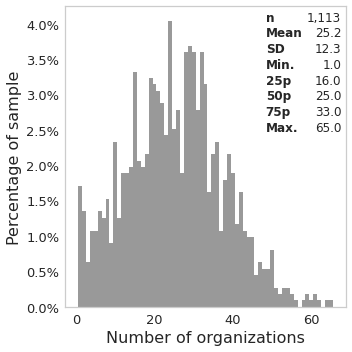

In [47]:
# plot
_, ax = init_mpl_fig((5, 5), 1)

sns.histplot(
    df_ind_num_orgs["n_orgs"],
    discrete=True,
    stat="percent",
    color=".5",
    alpha=0.8,
    edgecolor="none",
    linewidth=0,
    element="step", 
    fill=True,
    kde=False,
    ax=ax,
)

# ============================================================================
labsize = 16
ax.set_xlabel("Number of organizations", fontsize=labsize)
ax.set_ylabel("Percentage of sample", fontsize=labsize)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.1f}%"))
ax.tick_params(axis="both", labelsize=13, pad=0)
ax.grid(False)
plt.tight_layout()

save_mpl_fig("../figures/dist_org_per_user")

# ============================================================================
# Compute summary table
summary_stats = (
    df_ind_num_orgs["n_orgs"]
    .describe()
    .round(1)
    .loc[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]]
    .rename({
        "count": "n",
        "mean": "Mean",
        "std": "SD",
        "min": "Min.",
        "25%": "25p",
        "50%": "50p",
        "75%": "75p",
        "max": "Max."
    })
    .to_frame(name="Value")
    .rename_axis("Stat")
    .reset_index()
    .assign(
        Value=lambda d: d.apply(
            lambda row: f"{int(row['Value']):,}" if row["Stat"] == "n" else row["Value"],
            axis=1
        )
    )
)

# ============================================================================
# Add summary table
table = ax.table(
    cellText=summary_stats.values,
    cellLoc="left",
    # (left, bottom, width, height) in axes coords
    bbox=[0.7, 0.57, 0.3, 0.42],  
)

table.auto_set_font_size(False)
table.set_fontsize(12)

for (row, col), cell in table.get_celld().items():
    # Bold first column
    if col == 0:
        cell.set_text_props(weight="bold")
        cell.get_text().set_ha("left")
    elif col == 1:
        cell.get_text().set_ha("right")
    # remove borders
    cell.set_linewidth(0)

save_mpl_fig("../figures/dist_org_per_user_summtable")

### Distribution of Org Tracking Concentration Across Individuals

In [16]:
# compute gini
# minimum n_org required to enter compute
_threshold = 5
valid_caseid = df_ind_num_orgs.query(f"n_orgs >= {_threshold}")["caseid"]

df_gini = (
    df_individual_org_histshare
    .query(f"caseid in @valid_caseid")
    .groupby("caseid")["captured_hist"]
    .apply(lambda x: Gini(x.values).g)
    .reset_index(name="gini_exposure")
)
df_gini

,caseid,gini_exposure
0,47541,0.767795
1,56565,0.704780
2,203271,0.798789
3,216457,0.812889
4,257495,0.839820
...,...,...
1055,342368009,0.564583
1056,342376013,0.849781
1057,342383477,0.803518
1058,343195461,0.485124


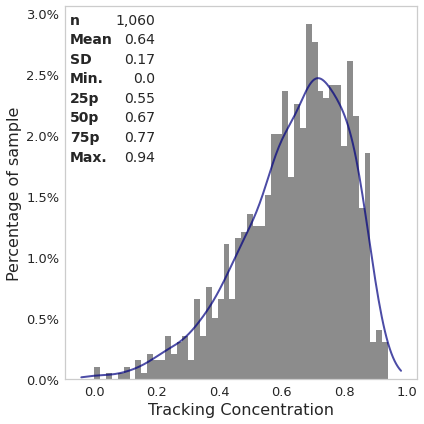

In [49]:
_, ax = init_mpl_fig((6,6), 1)

sns.histplot(
    df_gini["gini_exposure"],
    bins=50,
    kde=False,
    color=".5",
    alpha=.9,
    edgecolor="None",
    linewidth=0,
    element="step",     
    stat="density",
    ax=ax,
)

sns.kdeplot(
    df_gini["gini_exposure"],
    bw_adjust=1,
    cut=1,
    color="navy",
    alpha=.7,
    lw=2,
    ax=ax,
)

# ============================================================================
labsize = 16
plt.xlabel("Tracking Concentration", fontsize=labsize)
ax.set_ylabel("Percentage of sample", fontsize=labsize)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.1f}%"))
ax.tick_params(axis="both", labelsize=13, pad=0)
ax.grid(False)
plt.tight_layout()

save_mpl_fig("../figures/dist_tracking_concentration_per_user")

# ============================================================================
summary_stats = (
    df_gini["gini_exposure"]
    .describe()
    .round(2)
    .loc[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]]
    .rename({
        "count": "n",
        "mean": "Mean",
        "std": "SD",
        "min": "Min.",
        "25%": "25p",
        "50%": "50p",
        "75%": "75p",
        "max": "Max."
    })
    .to_frame(name="Value")
    .rename_axis("Stat")
    .reset_index()
    .assign(
        Value=lambda d: d.apply(
            lambda row: f"{int(row['Value']):,}" if row["Stat"] == "n" else row["Value"],
            axis=1
        )
    )
)

# ============================================================================
# Add summary table
table = ax.table(
    cellText=summary_stats.values,
    cellLoc="left",
    # (left, bottom, width, height) in axes coords
    bbox=[0.0, 0.57, 0.27, 0.42],  
)
#     bbox=[0.7, 0.57, 0.3, 0.42],  

table.auto_set_font_size(False)
table.set_fontsize(14)

for (row, col), cell in table.get_celld().items():
    # Bold first column
    if col == 0:
        cell.set_text_props(weight="bold")
        cell.get_text().set_ha("left")
    elif col == 1:
        cell.get_text().set_ha("right")
    # remove borders
    cell.set_linewidth(0)
    
save_mpl_fig("../figures/dist_tracking_concentration_per_user_summtable")    

### Tracking Breadth vs. Concentration

In [18]:
df_n_owners = (
    df_individual_org_histshare
    .groupby("caseid")["org"]
    .nunique()
    .reset_index(name="n_orgs")
)
df_n_owners

,caseid,n_orgs
0,47541,52
1,56565,39
2,203271,20
3,216457,15
4,257495,30
...,...,...
1108,342368009,30
1109,342376013,32
1110,342383477,15
1111,343195461,9


In [19]:
df_gini = df_gini.merge(df_n_owners, on="caseid")

$$
\text{Gini}_{\text{max}} = \frac{n - 1}{n}
$$


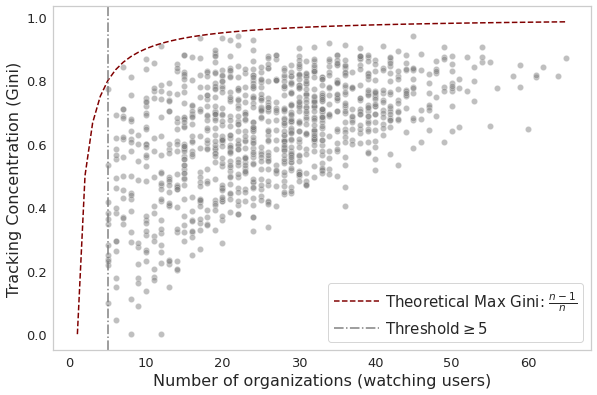

In [33]:
_, ax = init_mpl_fig((12,8), .7)

sns.scatterplot(
    data=df_gini,
    x="n_orgs", y="gini_exposure",
    color=".5",
    alpha=0.5, s=39
)

# ============================================================================
labsize = 16
plt.xlabel("Number of organizations (watching users)", fontsize=labsize)
ax.set_ylabel("Tracking Concentration (Gini)", fontsize=labsize)
ax.tick_params(axis="both", labelsize=13, pad=0)
ax.grid(False)
plt.tight_layout()

# ============================================================================
# envelop of theoretical max Gini
x = np.arange(1, df_gini["n_orgs"].max() + 1)
gini_max = (x - 1) / x

plt.plot(
    x,
    gini_max,
    color="maroon",
    linestyle="--",
    label=r"Theoretical Max Gini: $\frac{n - 1}{n}$"
)

ax.axvline(
    _threshold,
    color=".5",
    linestyle="dashdot",
    linewidth=1.5,
    label=r"Threshold$\geq$" f"{_threshold}"
)

plt.legend(
    fontsize=15,
    handlelength=3,  
    handletextpad=0.4,
)


## Top trackers: reach v dominance

In [21]:
df_org_reach = (
    df_individual_org_histshare
    .groupby("org")["caseid"]
    .nunique()
    .sort_values(ascending=False)
    .reset_index(name="n_users_seen")
)
df_org_reach

,org,n_users_seen
0,Collective Roll,998
1,Google LLC,983
2,"Twitter, Inc.",974
3,ID5 Technology Ltd,957
4,Snap Inc.,935
...,...,...
323,"Wikimedia Foundation, Inc.",1
324,Worldstar LLC.,1
325,A-FIS PTE. LTD.,1
326,webgarden s.r.o.,1


In [22]:
df_top_org = (
    df_individual_org_histshare
    .sort_values(["caseid", "captured_hist"], ascending=[True, False])
    .drop_duplicates("caseid")
    .groupby("org")
    .size()
    .sort_values(ascending=False)
    .reset_index(name="n_users_where_top")
)
df_top_org

,org,n_users_where_top
0,"Facebook, Inc.",228
1,Google LLC,169
2,"Taboola, Inc.",132
3,Collective Roll,94
4,Snap Inc.,83
5,"Twitter, Inc.",72
6,ID5 Technology Ltd,52
7,unpkg,46
8,"Bidtellect, Inc",41
9,easyAd Deutschland GmbH,23


In [23]:
df_org_summary = (
    df_org_reach
    .merge(df_top_org, on="org", how="outer")
    .fillna(0)
    .astype({"n_users_seen": int, "n_users_where_top": int})
    .sort_values("n_users_where_top", ascending=False)
)
df_org_summary

,org,n_users_seen,n_users_where_top
105,"Facebook, Inc.",889,228
121,Google LLC,983,169
281,"Taboola, Inc.",757,132
72,Collective Roll,998,94
259,Snap Inc.,935,83
...,...,...,...
116,"Geniee, inc.",1,0
115,"Gannett Co., Inc.",1,0
113,FullStory,29,0
112,Freepik Company,1,0


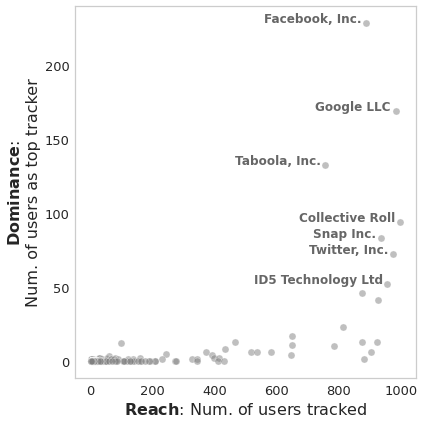

In [35]:
_, ax = init_mpl_fig((6,6), 1)

sns.scatterplot(
    data=df_org_summary,
    x="n_users_seen",
    y="n_users_where_top",
    color=".5",
    alpha=0.5,
    s=50,
     ax=ax,
)

# ============================================================================
labsize = 16
plt.xlabel(r"$\bf{Reach}$:" " Num. of users tracked", fontsize=labsize)
ax.set_ylabel(r"$\bf{Dominance}$:" "\nNum. of users as top tracker", fontsize=labsize)
ax.tick_params(axis="both", labelsize=13, pad=0)
ax.grid(False)
plt.tight_layout()

save_mpl_fig("../figures/top_trackers_reach_dominance")


# ============================================================================
# Create text labels
_top_threshold = 50
top_labels = df_org_summary.query(f"n_users_where_top >= {_top_threshold}").copy()

offset_x = -15  # shift to the left
offset_y = 3   # shift slightly upward
texts = [
    plt.text(
        row["n_users_seen"] + offset_x,
        row["n_users_where_top"] + offset_y,
        row["org"],
        fontsize=12,
        fontweight="bold", 
        color="0.4",  
        ha="right",         
        va="center",       
        rotation=0,
    )
    for _, row in top_labels.iterrows()
]
save_mpl_fig("../figures/top_trackers_reach_dominance_annotated_top_orgs")

### Organization market share

In [25]:
df_org_power = (
    df_individual_org_histshare
    .groupby("org")["captured_visits"]
    .sum()
    # highest below
    .sort_values(ascending=True)
    .reset_index(name="tt_captured_visits")
    .assign(
        cum_share=lambda df_: df_["tt_captured_visits"].cumsum()/ df_["tt_captured_visits"].sum(),
        prop_orgs=lambda df_: np.linspace(0, 1, len(df_)),
    )
)
df_org_power

,org,tt_captured_visits,cum_share,prop_orgs
0,CM Group,1,3.523388e-07,0.000000
1,"Charity Navigator, Inc.",1,7.046777e-07,0.003058
2,Shinobi Online LLC,1,1.057017e-06,0.006116
3,Go Travel Un Limited,1,1.409355e-06,0.009174
4,Veer West LLC.,2,2.114033e-06,0.012232
...,...,...,...,...
323,"Bidtellect, Inc",147201,5.678589e-01,0.987768
324,Collective Roll,191726,6.354114e-01,0.990826
325,Google LLC,277406,7.331523e-01,0.993884
326,"Taboola, Inc.",307823,8.416103e-01,0.996942


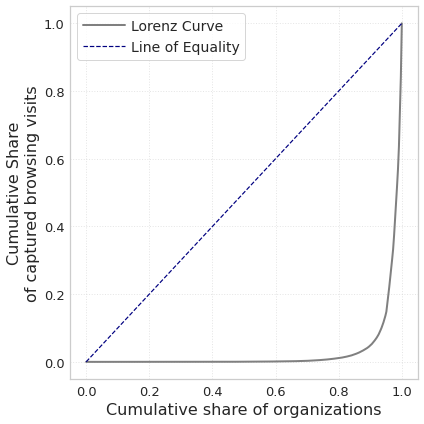

In [36]:
_, ax = init_mpl_fig((6,6), 1)

plt.plot(
    df_org_power["prop_orgs"],
    df_org_power["cum_share"],
    color=".5",
    linewidth=2,
    label="Lorenz Curve"
)

plt.plot([0, 1], [0, 1], linestyle="--", color="navy", linewidth=1.2, label="Line of Equality")

labsize = 16
plt.xlabel("Cumulative share of organizations", fontsize=labsize)
plt.ylabel("Cumulative Share\nof captured browsing visits", fontsize=labsize)
ax.tick_params(axis="both", labelsize=13, pad=0)
plt.grid(axis="both", linestyle=":", alpha=0.5)

plt.legend(
    fontsize=14,
    handlelength=3,  
    handletextpad=0.4,
)
plt.tight_layout()
save_mpl_fig("../figures/lorenz_org_share_browsinghist")

## Individual-level derived tracking measures